## AutoEncoder

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import os
from glob import glob
import pandas as pd

In [7]:
import os
os.chdir("../")

In [8]:
pwd

'C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project'

In [6]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

In [9]:
file_path = './dataset/back2/back2/*.jpg'
target_path = './dataset/scratch_data/scratch_data/*.jpg'

file_list = glob(file_path)
target_list = glob(target_path)

In [10]:
file_list = file_list[:100000]
target_list = target_list[:100000]

In [11]:
len(target_list)

100000

### DataLoader 생성

In [12]:
data_dict = {'train_path':[], 'target_path':[]}

for i in range(len(file_list)):
    train_path = file_list[i]
    target_path = target_list[i]
    
    data_dict['train_path'].append(train_path)
    data_dict['target_path'].append(target_path)

train_df = pd.DataFrame(data_dict)

train_df.to_csv("./train.csv", mode='w')

In [13]:
df = pd.read_csv('./train.csv')

In [14]:
from torchvision import transforms

transforms_train = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor()]
)

In [15]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class pair_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0] 

    def __getitem__(self, index):   
        row = self.csv.iloc[index]                
        train_image = Image.open(row.train_path).convert('RGB') 
        target_image = Image.open(row.target_path).convert('RGB')
        
        if self.transform:
            train_image = self.transform(train_image) # 이미지에 transform 적용하기
            target_image = self.transform(target_image)

        return train_image, target_image  # 이미지와 target return하기

In [16]:
# dataset class 객체 만들기
dataset_train = pair_Dataset(df, 'train', transform=transforms_train)

from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  num_workers=0)

In [17]:
len(train_loader)

1000

### Encoder, Decoder

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16, 32, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2)
        )
        
        self.layer2 = nn.Sequential(
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 32, 3, padding=1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.shape[0], -1)
        return out


In [24]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 32, 3,2, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16, 3, 3, 2, 1,1),
                        nn.ReLU()
        )


    def forward(self,x):
        out = x.view(x.shape[0],32,56,56)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

### model 생성

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


In [28]:
decoder.load_state_dict(torch.load('./model/scratch_Decoder.pt'))
encoder.load_state_dict(torch.load('./model/scratch_Encoder.pt'))

<All keys matched successfully>

## Train

In [29]:
for i in tqdm(range(num_epoch)):
    for j,[train_img, target_img] in enumerate(train_loader):
      
        optimizer.zero_grad()
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        output = encoder(train_img)
        output = decoder(output)
        
        loss = loss_func(output, target_img)
        loss.backward()
        optimizer.step()
        
    if i%10==0:
        print('Epoch {0} // Loss : {1}'.format(i+1, loss))
        torch.save(encoder.state_dict(), './model/scratch_Encoder.pt')
        torch.save(decoder.state_dict(), './model/scratch_Decoder.pt')

  1%|▊                                                                                     | 1/100 [08:06<13:22:00, 486.06s/it]

Epoch 1 // Loss : 0.01277233101427555


 11%|█████████▍                                                                            | 11/100 [50:13<6:15:26, 253.11s/it]

Epoch 11 // Loss : 0.011194976978003979


 21%|█████████████████▋                                                                  | 21/100 [1:32:21<5:32:57, 252.88s/it]

Epoch 21 // Loss : 0.01102654542773962


 31%|██████████████████████████                                                          | 31/100 [2:14:34<4:52:11, 254.08s/it]

Epoch 31 // Loss : 0.010940114967525005


 41%|██████████████████████████████████▍                                                 | 41/100 [2:56:47<4:09:16, 253.50s/it]

Epoch 41 // Loss : 0.010884622111916542


 51%|██████████████████████████████████████████▊                                         | 51/100 [3:39:11<3:27:42, 254.34s/it]

Epoch 51 // Loss : 0.010856211185455322


 61%|███████████████████████████████████████████████████▏                                | 61/100 [4:21:40<2:45:54, 255.25s/it]

Epoch 61 // Loss : 0.010814152657985687


 71%|███████████████████████████████████████████████████████████▋                        | 71/100 [5:04:02<2:02:57, 254.38s/it]

Epoch 71 // Loss : 0.010786147788167


 81%|████████████████████████████████████████████████████████████████████                | 81/100 [5:46:34<1:20:48, 255.19s/it]

Epoch 81 // Loss : 0.010818259790539742


 91%|██████████████████████████████████████████████████████████████████████████████▎       | 91/100 [6:29:08<38:21, 255.77s/it]

Epoch 91 // Loss : 0.010759289376437664


100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [7:07:27<00:00, 256.48s/it]


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)

decoder.load_state_dict(torch.load('./model/scratch_Decoder.pt'))
encoder.load_state_dict(torch.load('./model/scratch_Encoder.pt'))

<All keys matched successfully>

In [31]:
from PIL import Image

test_image = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\dataset\\back2\\back2\\55545.jpg').convert('RGB') 
test_target = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\dataset\\scratch_data\\scratch_data\\55545.jpg').convert('RGB')

test_image = transforms_train(test_image).unsqueeze(dim=0).to(device)
test_target = transforms_train(test_target).to(device)

print(test_image.shape)
print(test_target.shape)

test_output = encoder(test_image)
test_output = decoder(test_output)

print(torch.squeeze(test_image).shape)

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [32]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


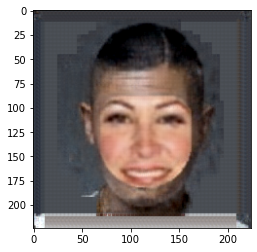

In [33]:
plt.imshow(torch.squeeze(test_output).cpu().detach().numpy().transpose(1, 2, 0))

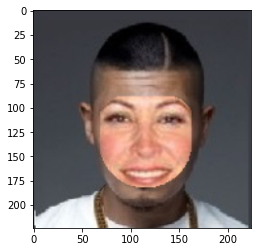

In [34]:
plt.imshow(torch.squeeze(test_target).cpu().detach().numpy().transpose(1, 2, 0))